In [1]:
import os
import random
import shutil
import tensorflow as tf
import zipfile
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# %cd /content/gdrive/MyDrive/42028/AT2
# !unzip data.zip
# %cd data

In [4]:
# Set random seed
random.seed(14337911)

# Define directories
source_dir = '/content/gdrive/MyDrive/42028/AT2/Image_Classification/dataset_14337911'
train_dir = '/content/gdrive/MyDrive/42028/AT2/Image_Classification/train'
valid_dir = '/content/gdrive/MyDrive/42028/AT2/Image_Classification/valid'
test_dir = '/content/gdrive/MyDrive/42028/AT2/Image_Classification/test'

# Create train, valid, and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each source directory
for dirpath, dirnames, filenames in os.walk(source_dir):
    
    # Skip the source directory itself
    if dirpath == source_dir:
        continue
    
    # Create corresponding train, valid, and test directories
    rel_path = os.path.relpath(dirpath, source_dir)
    train_path = os.path.join(train_dir, rel_path)
    valid_path = os.path.join(valid_dir, rel_path)
    test_path = os.path.join(test_dir, rel_path)
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(valid_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    
    # Split files into train, valid, and test sets
    files = os.listdir(dirpath)
    random.shuffle(files)
    n_train = int(len(files) * 0.6)
    n_valid = int(len(files) * 0.2)
    train_files = files[:n_train]
    valid_files = files[n_train:n_train+n_valid]
    test_files = files[n_train+n_valid:]
    
    # Copy files to train directory
    for filename in train_files:
        src_path = os.path.join(dirpath, filename)
        dst_path = os.path.join(train_path, filename)
        shutil.copy(src_path, dst_path)
    
    # Copy files to valid directory
    for filename in valid_files:
        src_path = os.path.join(dirpath, filename)
        dst_path = os.path.join(valid_path, filename)
        shutil.copy(src_path, dst_path)

    # Copy files to test directory
    for filename in test_files:
        src_path = os.path.join(dirpath, filename)
        dst_path = os.path.join(test_path, filename)
        shutil.copy(src_path, dst_path)


In [5]:
train_count = sum([len(files) for r, d, files in os.walk(train_dir)])
valid_count = sum([len(files) for r, d, files in os.walk(valid_dir)])
test_count = sum([len(files) for r, d, files in os.walk(test_dir)])

print("Number of files in train directory:", train_count)
print("Number of files in validation directory:", valid_count)
print("Number of files in test directory:", test_count)

Number of files in train directory: 1975
Number of files in validation directory: 652
Number of files in test directory: 679


In [17]:
model = tf.keras.models.Sequential([
    #Conv_1          #original model was built for input shape of 224X224
    tf.keras.layers.Conv2D(96, (11,11),strides=4, padding='valid', activation='relu', input_shape=(224, 224, 3)),
    # Pooling_1
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='valid'),
    # Batch Normalisation_1
    tf.keras.layers.BatchNormalization(),
    # Conv_2
    tf.keras.layers.Conv2D(256, (5,5),strides=1, padding='valid', activation='relu'),
    # Pooling_2
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='valid'),
    #Batch Normalisation_2
    tf.keras.layers.BatchNormalization(),
    # Conv_3
    tf.keras.layers.Conv2D(384, (3,3),strides=1, padding='valid', activation='relu'),
    # Batch Normalisation_3
    tf.keras.layers.BatchNormalization(),
    # Conv_4
    tf.keras.layers.Conv2D(384, (3,3),strides=1, padding='valid', activation='relu'),
    # Batch Normalisation_3
    tf.keras.layers.BatchNormalization(),
    #conv_5
    tf.keras.layers.Conv2D(256, (3,3),strides=1, padding='valid', activation='relu'),
    #pooling_3
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='valid'),
    #Batch Normalization_4
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    #Dense layer_1
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    #Dense layer_2
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    #Dense layer_3
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(20, activation='softmax')  # 20 classes
    ])


In [18]:
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

Found 1975 images belonging to 20 classes.
Found 652 images belonging to 20 classes.


In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [9]:
#checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=1, save_freq='epoch')
filepath='/tmp/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

In [21]:
# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=1975//20,  
      epochs=100,
      validation_data=validation_generator,
      validation_steps=652//20, 
      callbacks = [checkpoint],
      verbose=2)

Epoch 1/100
98/98 - 30s - loss: 3.3847 - acc: 0.1187 - val_loss: 3.2543 - val_acc: 0.0641 - 30s/epoch - 309ms/step
Epoch 2/100
98/98 - 30s - loss: 3.3119 - acc: 0.1258 - val_loss: 3.3953 - val_acc: 0.0781 - 30s/epoch - 311ms/step
Epoch 3/100
98/98 - 30s - loss: 3.2050 - acc: 0.1519 - val_loss: 2.8154 - val_acc: 0.1781 - 30s/epoch - 305ms/step
Epoch 4/100
98/98 - 30s - loss: 3.1716 - acc: 0.1427 - val_loss: 2.4553 - val_acc: 0.2656 - 30s/epoch - 307ms/step
Epoch 5/100
98/98 - 30s - loss: 3.1964 - acc: 0.1668 - val_loss: 2.4523 - val_acc: 0.2734 - 30s/epoch - 306ms/step
Epoch 6/100
98/98 - 30s - loss: 3.0526 - acc: 0.1775 - val_loss: 2.6550 - val_acc: 0.2469 - 30s/epoch - 306ms/step
Epoch 7/100
98/98 - 30s - loss: 2.9979 - acc: 0.1959 - val_loss: 3.4293 - val_acc: 0.2453 - 30s/epoch - 305ms/step
Epoch 8/100
98/98 - 30s - loss: 2.9911 - acc: 0.1918 - val_loss: 2.4130 - val_acc: 0.3313 - 30s/epoch - 304ms/step
Epoch 9/100
98/98 - 30s - loss: 2.9450 - acc: 0.1954 - val_loss: 2.9639 - val_ac

In [29]:
model.save('/content/gdrive/MyDrive/42028/AT2/baseline_alexnet.h5')

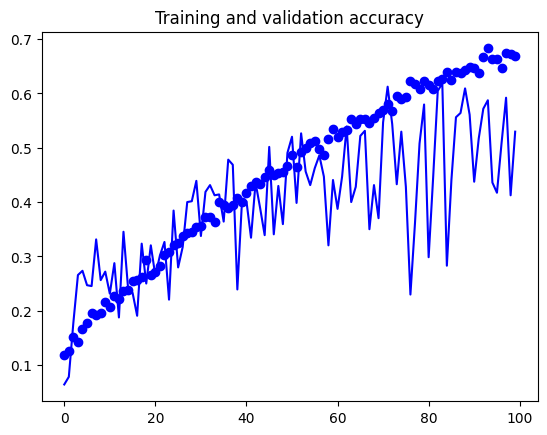

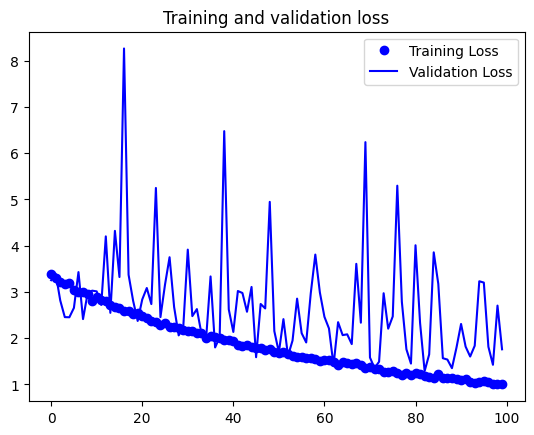

In [23]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Use the generator to load the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',  # Use 'categorical' if your model uses categorical_crossentropy loss
    shuffle=False)  # Important: do not shuffle test data

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print("Test accuracy:", accuracy)


Found 679 images belonging to 20 classes.
33/33 [==============================] - 3s 85ms/step - loss: 1.6844 - acc: 0.5439
Test accuracy: 0.5439394116401672


1/1 [==============================] - 0s 24ms/step


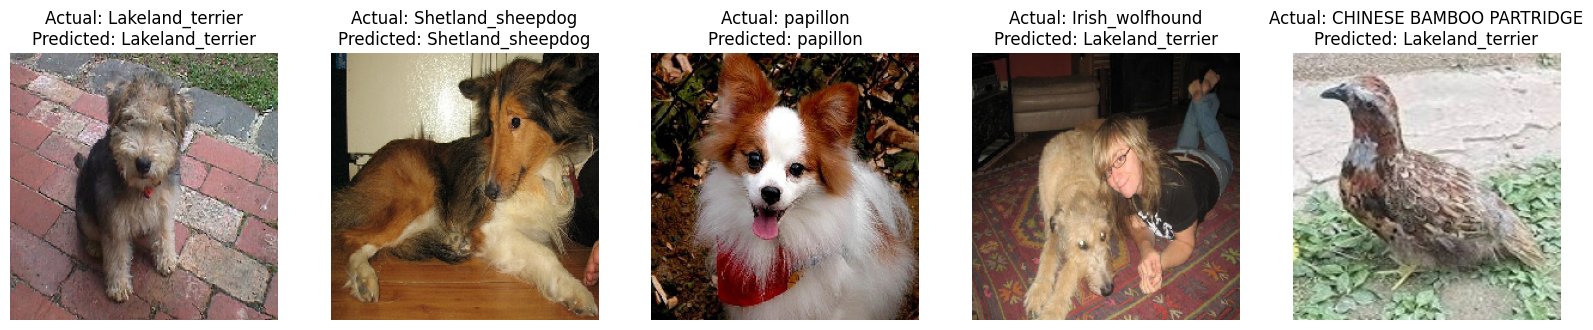

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import keras.utils as image

# Function to print the class labels
def print_class_labels(generator, predicted_indices):
    labels = dict((v,k) for k,v in generator.class_indices.items())
    predictions = [labels[k] for k in predicted_indices]
    return predictions

# Select random images from test set
num_images = 5
random_test_images = np.random.choice(test_generator.filenames, num_images)

# Display images with their labels and predicted classes
fig, axes = plt.subplots(1, num_images, figsize=(20,20))

for i in range(num_images):
    img = image.load_img(test_dir + '/' + random_test_images[i], target_size=(224, 224))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor = np.expand_dims(img_tensor, axis=0)  # Add batch dimension
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

    # Predict the image
    prediction = model.predict(img_tensor)
    predicted_class = np.argmax(prediction)

    # Get the class label
    actual_label = os.path.split(random_test_images[i])[0]
    predicted_label = print_class_labels(test_generator, [predicted_class])[0]

    # Show the image
    axes[i].imshow(img_tensor[0])
    axes[i].axis('off')
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.show()


In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 27, 27, 96)       384       
 hNormalization)                                                 
                                                                 
 conv2d_16 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 11, 11, 256)      0         
 g2D)                                                            
                                                      

Customised AlexNet

In [30]:
from keras.models import load_model

# Load the baseline model
baseline_model = load_model('/content/gdrive/MyDrive/42028/AT2/baseline_alexnet.h5')

In [39]:
# Remove the second last dense layer (4096 units) 
# Add a convolutional layer after the last convolutional layer

new_model = tf.keras.models.Sequential([
    # The first 13 layers are the same as the baseline model
    tf.keras.layers.Conv2D(96, (11,11),strides=4, padding='valid', activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (5,5),strides=1, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(384, (3,3),strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(384, (3,3),strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3),strides=1, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='valid'),
    tf.keras.layers.BatchNormalization(),

    # Added an extra convolutional layer
    tf.keras.layers.Conv2D(256, (2,2),strides=1, padding='valid', activation='relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    
    # Removed second last layer
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(20, activation='softmax')  # 20 classes
])



In [41]:
# transferring weights for the first 13 layers which are the same in both models
for new_layer, layer in zip(new_model.layers[:13], baseline_model.layers[:13]):
    new_layer.set_weights(layer.get_weights())


In [42]:
# Compile the model
new_model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [43]:
# Train the model
new_history = new_model.fit(
      train_generator,
      steps_per_epoch=1975//20,  
      epochs=100,
      validation_data=validation_generator,
      validation_steps=652//20, 
      callbacks = [checkpoint],
      verbose=2)

Epoch 1/100
98/98 - 35s - loss: 2.8047 - acc: 0.2184 - val_loss: 3.4100 - val_acc: 0.2266 - 35s/epoch - 357ms/step
Epoch 2/100
98/98 - 30s - loss: 1.9688 - acc: 0.4286 - val_loss: 2.3524 - val_acc: 0.3891 - 30s/epoch - 308ms/step
Epoch 3/100
98/98 - 30s - loss: 1.7565 - acc: 0.4854 - val_loss: 1.8860 - val_acc: 0.5312 - 30s/epoch - 304ms/step
Epoch 4/100
98/98 - 30s - loss: 1.5938 - acc: 0.5309 - val_loss: 2.2167 - val_acc: 0.5063 - 30s/epoch - 309ms/step
Epoch 5/100
98/98 - 30s - loss: 1.4945 - acc: 0.5565 - val_loss: 3.3924 - val_acc: 0.4172 - 30s/epoch - 308ms/step
Epoch 6/100
98/98 - 30s - loss: 1.4929 - acc: 0.5575 - val_loss: 2.6956 - val_acc: 0.4547 - 30s/epoch - 304ms/step
Epoch 7/100
98/98 - 30s - loss: 1.3591 - acc: 0.5831 - val_loss: 2.4456 - val_acc: 0.4031 - 30s/epoch - 306ms/step
Epoch 8/100
98/98 - 30s - loss: 1.3060 - acc: 0.5990 - val_loss: 4.5938 - val_acc: 0.3984 - 30s/epoch - 305ms/step
Epoch 9/100
98/98 - 30s - loss: 1.2715 - acc: 0.6148 - val_loss: 3.3359 - val_ac

In [44]:
new_model.save('/content/gdrive/MyDrive/42028/AT2/custom_alexnet.h5')

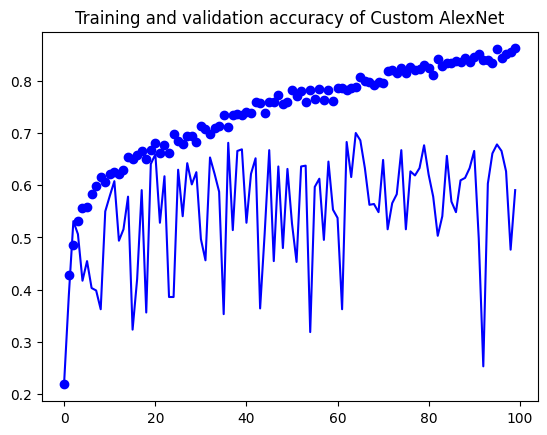

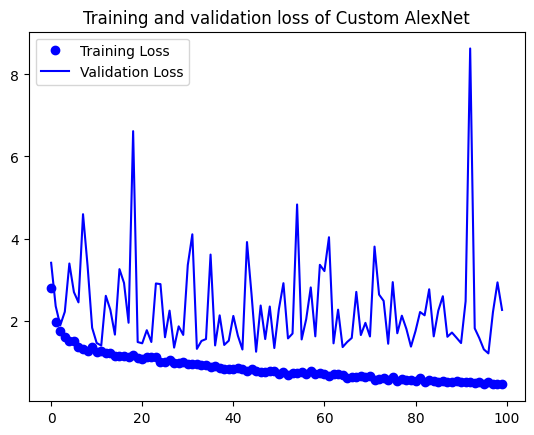

In [48]:
import matplotlib.pyplot as plt
acc = new_history.history['acc']
val_acc = new_history.history['val_acc']
loss = new_history.history['loss']
val_loss = new_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy of Custom AlexNet')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss of Custom AlexNet')
plt.legend()

plt.show()

In [50]:
# Evaluate the model on the test data
loss, accuracy = new_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print("Test accuracy:", accuracy)

33/33 [==============================] - 3s 84ms/step - loss: 1.9383 - acc: 0.6333
Test accuracy: 0.6333333253860474


1/1 [==============================] - 0s 23ms/step


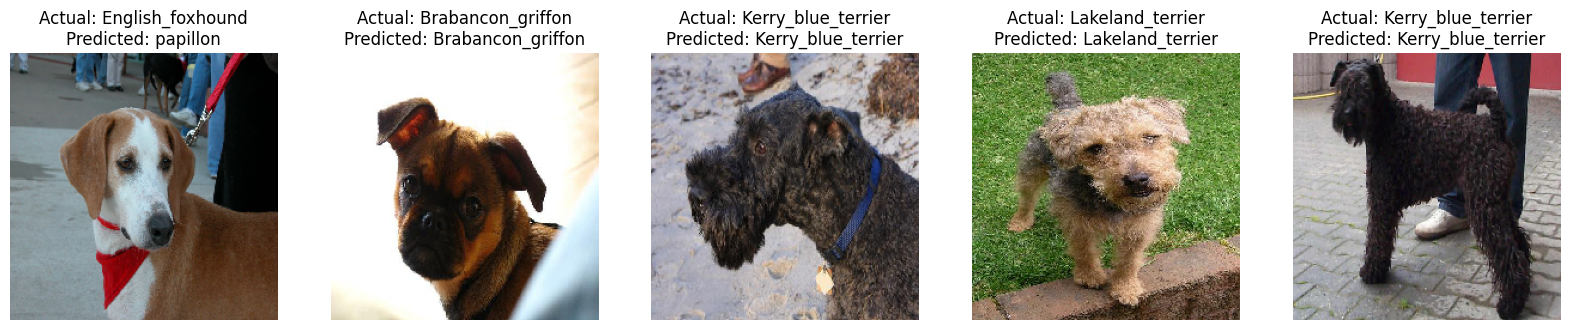

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import keras.utils as image

# Function to print the class labels
def print_class_labels(generator, predicted_indices):
    labels = dict((v,k) for k,v in generator.class_indices.items())
    predictions = [labels[k] for k in predicted_indices]
    return predictions

# Select random images from test set
num_images = 5
random_test_images = np.random.choice(test_generator.filenames, num_images)

# Display images with their labels and predicted classes
fig, axes = plt.subplots(1, num_images, figsize=(20,20))

for i in range(num_images):
    img = image.load_img(test_dir + '/' + random_test_images[i], target_size=(224, 224))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor = np.expand_dims(img_tensor, axis=0)  # Add batch dimension
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

    # Predict the image
    prediction = new_model.predict(img_tensor)
    predicted_class = np.argmax(prediction)

    # Get the class label
    actual_label = os.path.split(random_test_images[i])[0]
    predicted_label = print_class_labels(test_generator, [predicted_class])[0]

    # Show the image
    axes[i].imshow(img_tensor[0])
    axes[i].axis('off')
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.show()

In [59]:
new_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_32 (Bat  (None, 27, 27, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_39 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 11, 11, 256)      0         
 g2D)                                                            
                                                      